#### Notebook config

In [2]:
# %load ~/software/fullwavepy/fullwavepy/config/jupyter.py 
from fullwavepy import * # Load modules imported in fullwavepy/__init__.py
from arrau import *
# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook
# -----------------------------------------------------------------------------
# Set matplotlib backend
# -----------------------------------------------------------------------------
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# interactive plots displayed in a notebook cell
# %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# Set matplotlib style
# ----------------------------------------------------------------------------
plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot'])
# print(plt.style.available) 
# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers and load the log_lvl function
from fullwavepy.config.logging import *
# -----------------------------------------------------------------------------
# Set level of log-messages
log_lvl(20) 
# Other options in order of increasing importance and 
# decreasing verbosity:
# TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50, respectively
# -----------------------------------------------------------------------------
# Autocompleting
# -----------------------------------------------------------------------------
#  Not sure if it works
#%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2
from matplotlib.gridspec import GridSpec
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])

# import matplotlib as mpl
# COLOR = 'Gray'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


In [3]:
exe = { 
    'fullwave':  '~/PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'fullwave_local': '/home/kmc3817/light_PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'segyprep':  '/home/kmc3817/light_PhD/fullwave3D/segyprep_v3.16/bin/segyprep_v3.16'} 

In [4]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100, kernel='lo',
             anisotropy='none'):
        self.nth = nth
        self.kernel = kernel
        self.anisotropy = anisotropy
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=100000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, 
                        kernel=self.kernel, anisotropy=self.anisotropy, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        extent = np.array(extent) / 1000 # km
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            convert = 1000
            extent = np.array(self.b01.extent) / convert # km
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:]/convert, # convert to km/s
                          extent=[extent[0], extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp / 1000
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    convert = 1000
    s = [en.srcs['soux0']/convert, en.srcs['souz']/convert]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot_old(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        
def plot_all(en, save, animate, steps=None, signs=None):
    if signs is None:
        signs = ['0', '-', '+']
    if steps is None:
        steps = np.arange(en.nth, en.d01['ns']+1, en.nth)
    for sign in signs:
        for ts in steps:
            if 1:
                ref = '0'
                rec1_c = 'g'
                rec2_c = 'm'
                clip=500
                alpha=.7 
                trids=[-300,-20]
                tmax = en.d01['ns']*en.d01['dt']
                tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
            if 1:
                # Prerequisites
                x1, x2, y1, y2, z1, z2 = en.b01.box
                dx = en.d01['dx']
                dt = en.d01['dt']
                recx = np.arange(x1, x2+dx, dx)
                z = (z2 - z1) / 2
                vmin, vmax = vmin_vmax(en)
                p = en.p[sign]
                p_ref = en.p[ref]
            if 1:
                fig = figure(10,5)
                fig.set_tight_layout(dict(pad=.1))
                gs = GridSpec(1,1)
                ax = fig.add_subplot(gs[0])
                p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
                p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
                plot_src(en, size=15)
                convert = 1000
                recx = np.arange(x1, x2+dx, dx) / convert
                z = (z2 - z1) / 2 / convert
                kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
                plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
                plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
                ax.set_xlabel('X (km)')
                ax.set_ylabel('Z (km)')
                ax.set_xlim(p.tvp.axes[0].extent)
                ax.set_ylim(p.tvp.axes[1].extent)
                ax.invert_yaxis()
                ax.set_aspect('equal') 
                ax.set_title('Time: %1.4f s' % (ts * dt))    
            if 1:
                from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
                time = np.arange(en.d01['ns']) * dt
                for i in range(2):
                    trid = trids[i]
                    if i == 0:
                        rec_c = rec1_c
                        loc  = 'upper left' 
                        tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                        tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                        ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                    else:
                        rec_c = rec2_c
                        loc = 'lower left'
                        tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                        tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                        ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                    axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                         )
                    axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                    axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                    axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                               marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                    axins.set(**ax_pars)
                    axins.tick_params(**tick_pars)
                    axins.tick_params(**tick_lab_pars)
            if save:
                fname = 'figures/%s_%s.pdf' % (p.name, str(ts).rjust(6, '0')) 
                plt.savefig(fname)
                plt.close()
        if animate:
            !cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif

# Do

In [ ]:
%%time 
for r in [0.25, 0.5, 0.75]:
    for A in [0.75, 0.5, 0.25]:
        en = Ensemble('square', './', exe, anom_rad_per_wavelen=r, anom_amp=A)
        en.init_pars(x2=1.5e4, ns=3000, babs=200, eabs=250, kernel='lo', anisotropy='none')
        en.init_projs()
        #en.prep_inp()
        #en.run()
        en.prep_out()
        plot_all(en, save=1, animate=0)

Dominant wavelength in the background Vp: 1.0 km


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Dominant wavelength in the background Vp: 1.0 km
Dominant wavelength in the background Vp: 1.0 km
Dominant wavelength in the background Vp: 1.0 km
Dominant wavelength in the background Vp: 1.0 km
Dominant wavelength in the background Vp: 1.0 km
Dominant wavelength in the background Vp: 1.0 km
Dominant wavelength in the background Vp: 1.0 km


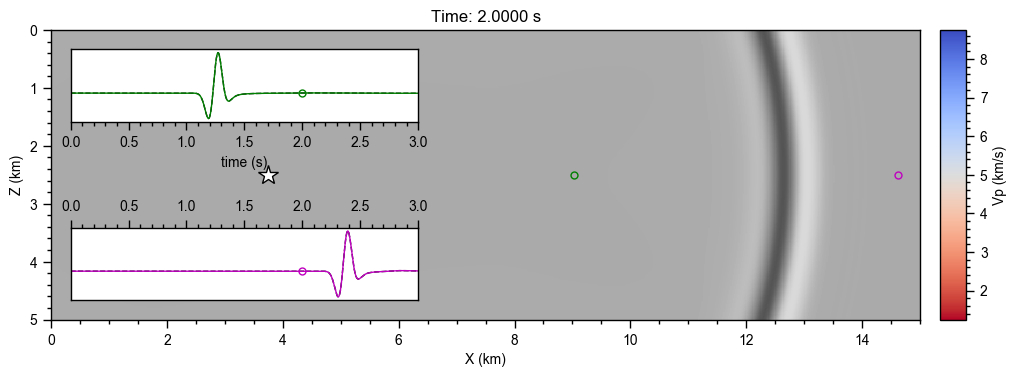

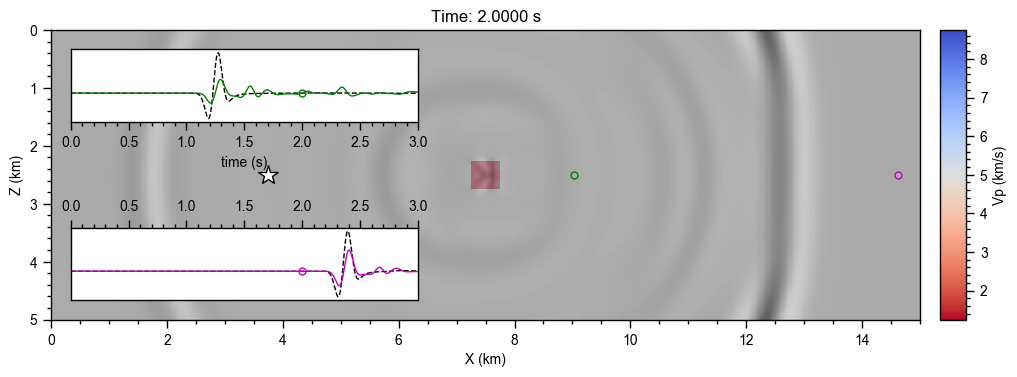

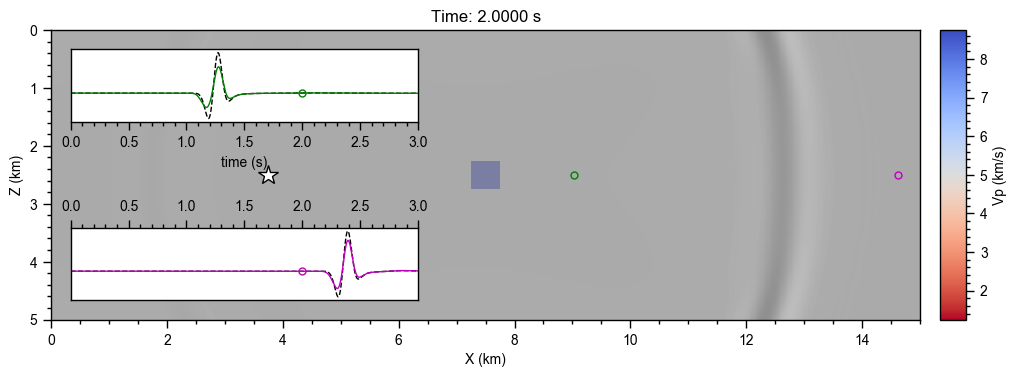

In [67]:
plot_all(en, save=0, animate=0, steps=[2000])

# ...